In [1]:
import os
import sys
import pandas as pd
import numpy as np

from dataclasses import dataclass
from nomadic.pipeline.qcbams.plot import MappingStatesAndColors


import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 300

## Auxiliary

In [2]:
def get_experiment_dir(expt, barcoding="single_end"):
    d = f"../experiments/{expt}/nomadic/guppy/hac/{barcoding}"
    return d

def load_mapping_df(expt, barcoding="single_end", state="primary"):
    expt_dir = get_experiment_dir(expt, barcoding)
    df = pd.read_csv(f"{expt_dir}/qc-bams/table.mapping.{state}_state.csv")
    return df

def load_balance_df(expt, barcoding="single_end"):
    expt_dir = get_experiment_dir(expt, barcoding)
    df = pd.read_csv(f"{expt_dir}/target-extraction/table.target_coverage.overview.csv")
    return df

In [3]:
def load_seq_effiency(expt, barcoding="single_end"):
    expt_dir = get_experiment_dir(expt, barcoding)
    df = pd.read_csv(
        f"../../nomadic/experiments/{expt_dir}"
        "/qc-efficiency/table.overall.effiency.csv")
    return df

In [4]:
msc = MappingStatesAndColors()

In [5]:
def rgb2hex(rgb_tuple, M=255):
    return "#{:02x}{:02x}{:02x}".format(*[int(M*v) for v in rgb_tuple])

## Load data

In [7]:
expt = "2021-11-14_strain-validation-flongle-lfb"
#expt = "2022-02-16_zmb-discards-8plex"

*NOMADIC*

In [8]:
eff_df = load_seq_effiency(expt)
eff_df.columns = ["subset", "n_reads", "n_bases"]

*NOMADIC2*

In [9]:
mapping_df = load_mapping_df(expt)
balance_df = load_balance_df(expt)

## Munge

In [10]:
# Focus on number of reads
eff_values = eff_df.drop("n_bases", axis=1)
eff_values.index = eff_values["subset"]
eff_values = eff_values["n_reads"].squeeze()

In [11]:
# Add failed categories
eff_values["n_failed_qc"] = eff_values["n_total"] - eff_values["n_passed_qc"]
eff_values["unclassified"] = eff_values["n_passed_qc"] - eff_values["n_barcoded"]
eff_values["n_offtarget"] = eff_values["n_mapped"] - eff_values["n_ontarget"]

In [12]:
eff_values

subset
n_total         345457.0
n_passed_qc     310110.0
n_barcoded      276489.0
n_mapped        212057.0
n_ontarget      198269.0
n_failed_qc      35347.0
unclassified     33621.0
n_offtarget      13788.0
Name: n_reads, dtype: float64

In [13]:
# Replace 'n_mapped' with pf/hs/unmapped breakdown
eff_values.drop("n_mapped", inplace=True)

In [14]:
map_values = mapping_df[msc.primary_levels].sum().squeeze()

In [15]:
eff_values = pd.concat([eff_values, map_values])
#assert len(eff_values) == 9

In [16]:
eff_values

n_total         345457.0
n_passed_qc     310110.0
n_barcoded      276489.0
n_ontarget      198269.0
n_failed_qc      35347.0
unclassified     33621.0
n_offtarget      13788.0
unmapped           334.0
hs_mapped        64077.0
pf_mapped       212038.0
dtype: float64

## Prepare plotting objects

In [104]:
EFF_ORDER = [
    "n_total",
    "n_failed_qc",
    "n_passed_qc",
    "unclassified",
    "n_barcoded",
    "unmapped",
    "hs_mapped",
    "pf_mapped",
    "n_offtarget",
    "n_ontarget",
]

In [105]:
len(EFF_ORDER)

10

In [106]:
eff_values = eff_values[EFF_ORDER]

In [107]:
colors = sns.color_palette("Greys_r", len(EFF_ORDER)).as_hex()
colors = [
    c
    if n not in msc.primary_levels 
    else rgb2hex(dict(zip(msc.primary_levels, msc.primary_colors))[n])
    for (n, c) in zip(EFF_ORDER, colors)
]

In [108]:
len(colors)

10

In [109]:
data_dt = {
    "index": np.arange(len(eff_values)),
    "name": eff_values.index.tolist(),
    "n_reads": eff_values.values,
}

In [110]:
link = {
    "source": [0, 0, 2, 2, 4, 4, 4, 7, 7],
    "target": [1, 2, 3, 4, 5, 6, 7, 8, 9],
    "value": eff_values.values[1:]
}

In [111]:
N = eff_values["n_total"]
INTV = 0.1
node = {
    
    # GENERAL AESTHETIC
    "pad": 15,
    "thickness": 15,
    "line": {"color": "black", "width": 0.5},
    
    # COLORS
    "color": colors, # sns.color_palette("inferno", len(EFF_ORDER)).as_hex(),
    
    # LABELS
    "label": [f"{n} ({100*v/N:.01f}%)" 
              for (n, v) in zip(data_dt["name"], data_dt["n_reads"])],
    
    
    # POSITIONING
    "x": [0] + [(1+s)*INTV for s in link["source"]],
    "y": [0] + [0.1]*len(eff_values[1:])
}

## INCLUDE GENES

In [112]:
gene_sum_df = (balance_df
               .query("overlap == 'any'")
               .groupby("gene_name")
               .sum()
              )["reads_total"]

In [125]:
gene_sum_df

gene_name
CRT1      6497.0
DHFR     20022.0
DHPS     35353.0
K13      33716.0
MDR1     54279.0
MSP2     11733.0
PMI      17290.0
PMIII    19363.0
Name: reads_total, dtype: float64

In [113]:
M = gene_sum_df.sum()
n_genes = len(gene_sum_df)
gene_labels = [f"{n} ({100*v/M:.01f}%)"
               for (n, v) in gene_sum_df.items()]

In [114]:
gene_colors = sns.color_palette("Spectral", n_genes).as_hex()

In [115]:
data_dt = {
    "index": np.arange(len(eff_values)),
    "name": eff_values.index.tolist(),
    "n_reads": eff_values.values,
}

In [116]:
link = {
    "source": [0, 0, 2, 2, 4, 4, 4, 7, 7] + [9]*n_genes,
    "target": [1, 2, 3, 4, 5, 6, 7, 8, 9] + list(range(10, 10*n_genes)),
    "value": list(eff_values.values[1:]) + list(gene_sum_df)
}

In [117]:
# Try and get resonable X positions
sources = np.unique(link["source"])
n_sources = sources.shape[0]
n_columns = n_sources + 1
INTV = 1 / n_columns
xpos = {s: INTV + INTV*i for i, s in enumerate(sources)}

In [118]:
N = eff_values["n_total"]
INTV = 0.1
node = {
    
    # GENERAL AESTHETIC
    "pad": 15,
    "thickness": 15,
    "line": {"color": "black", "width": 0.5},
    
    # COLORS
    "color": colors + gene_colors,
    
    # LABELS
    "label": [f"{n} ({100*v/N:.01f}%)" 
              for (n, v) in zip(data_dt["name"], data_dt["n_reads"])] + gene_labels,
    
    
    # POSITIONING
    "x": [0.001, 0.15, 0.15, 0.3, 0.3, 0.45, 0.45, 0.45, 0.6, 0.6] + [1]*8,
    "y": [0.001, 0.5, 0.001, 0.45, 0.001, 0.5, 0.35, 0.001, 0.3, 0.001] + list(np.linspace(-0.2, 0.2, 9))
}

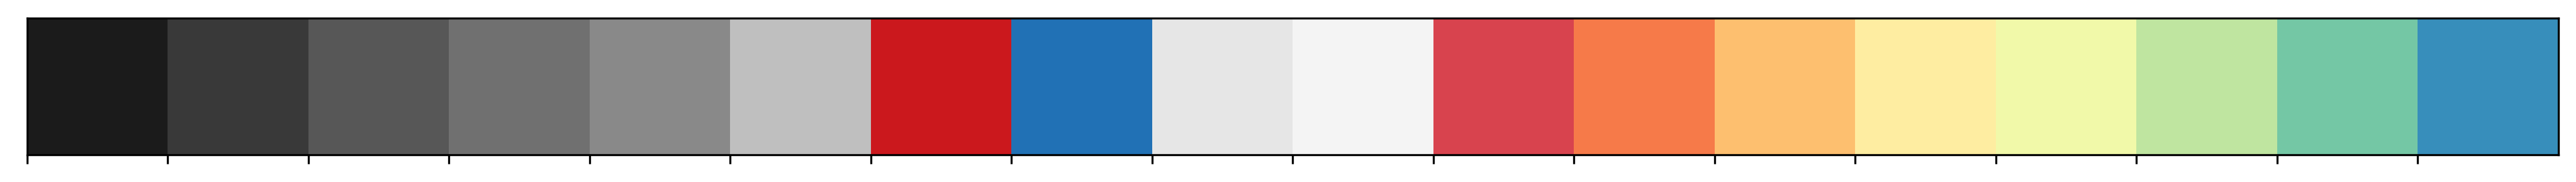

In [119]:
sns.palplot(colors + gene_colors)

## Plot

In [120]:
plot_data = go.Sankey(
    domain={'x': [0, 1], 'y': [0, 1]},
    link=link,
    node=node,
    arrangement="snap"
)

fig = go.Figure(plot_data)
fig.show()
fig.write_image(f"figures/fig2_seq-efficiency/fig2-sankey-{expt}.pdf")